# 2D Fast Accurate Fourier Transform
## with an extra gpu array for the 33th complex values

In [1]:
import numpy as np
import ctypes
from ctypes import *

import pycuda.gpuarray as gpuarray
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math


In [2]:
%matplotlib inline    


## Loading FFT routines

In [3]:
gridDIM = 64

size = gridDIM*gridDIM

axes0 = 0
axes1 = 1

makeC2C = 0
makeR2C = 1
makeC2R = 1

axesSplit_0 = 0
axesSplit_1 = 1

m = size

segment_axes0 = 0
segment_axes1 = 0

DIR_BASE = "/home/robert/Documents/new1/FFT/mycode/"

# FAFT 
_faft128_2D = ctypes.cdll.LoadLibrary( DIR_BASE+'FAFT128_2D_R2C.so' )
_faft128_2D.FAFT128_2D_R2C.restype = int
_faft128_2D.FAFT128_2D_R2C.argtypes = [ctypes.c_void_p, ctypes.c_void_p, 
                                         ctypes.c_float, ctypes.c_float, ctypes.c_int, 
                                         ctypes.c_int, ctypes.c_int, ctypes.c_int]

cuda_faft = _faft128_2D.FAFT128_2D_R2C

# Inv FAFT
_ifaft128_2D = ctypes.cdll.LoadLibrary( DIR_BASE+'IFAFT128_2D_C2R.so' )
_ifaft128_2D.IFAFT128_2D_C2R.restype = int
_ifaft128_2D.IFAFT128_2D_C2R.argtypes = [ctypes.c_void_p, ctypes.c_void_p, 
                                           ctypes.c_float, ctypes.c_float, ctypes.c_int, 
                                           ctypes.c_int, ctypes.c_int, ctypes.c_int]

cuda_ifaft = _ifaft128_2D.IFAFT128_2D_C2R

In [4]:
def fftGaussian(p,sigma):
    return np.exp( - p**2*sigma**2/2.  )

## Initializing Data

## Gaussian

In [5]:
def Gaussian(x,mu,sigma):
    return np.exp( - (x-mu)**2/sigma**2/2.  )/(sigma*np.sqrt( 2*np.pi  ))

def fftGaussian(p,mu,sigma):
    return np.exp(-1j*mu*p)*np.exp( - p**2*sigma**2/2.  )

 Amplitude x =  7.0
 Amplitude p =  5.0
        
mu_x =  1.5
mu_y =  1.5
sigma_x =  1.0
sigma_y =  1.0
   
n     =  64
dx    =  0.21875
dp    =  0.15625
           standard fft dp =  0.448798950513      
    
delta =  0.00543986621896
    
The Gaussian extends to the numerical error in single precision:
    min =  6.66874043919e-33


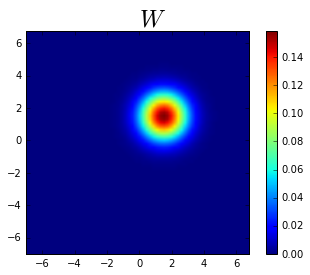

In [6]:
# Gaussian parameters
mu_x = 1.5
sigma_x = 1.

mu_y = 1.5
sigma_y = 1.

# Grid parameters
x_amplitude = 7.
p_amplitude = 5.                # With the traditional method p amplitude is fixed to: 2 * np.pi /( 2*x_amplitude ) 

dx = 2*x_amplitude/float(gridDIM)  # This is dx in Bailey's paper
dp = 2*p_amplitude/float(gridDIM)  # This is gamma in Bailey's paper

delta = dx*dp/(2*np.pi)

x_range = np.linspace( -x_amplitude, x_amplitude-dx, gridDIM) 
p_range = np.linspace( -p_amplitude, p_amplitude-dp, gridDIM) 

x = x_range[ np.newaxis, : ] 
y = x_range[ :, np.newaxis ] 

f =  Gaussian(x,mu_x,sigma_x)*Gaussian(y,mu_y,sigma_y)

plt.imshow( f, extent=[-x_amplitude , x_amplitude-dx, -x_amplitude , x_amplitude-dx] , origin='lower')

axis_font = {'size':'24'}
plt.text( 0., 7.1, '$W$' , **axis_font)
plt.colorbar()


#plt.ylim(0,0.44)


print ' Amplitude x = ',x_amplitude
print ' Amplitude p = ',p_amplitude
print '        '

print 'mu_x = ', mu_x
print 'mu_y = ', mu_y
print 'sigma_x = ', sigma_x
print 'sigma_y = ', sigma_y
print '   '

print 'n     = ', x.size
print 'dx    = ', dx
print 'dp    = ', dp
print '           standard fft dp = ',2 * np.pi /( 2*x_amplitude ) , '     '
print '    '
print 'delta = ', delta


print '    '

print 'The Gaussian extends to the numerical error in single precision:'  
print '    min = ', np.min(f)


## $W$ TRANSFORM FROM AXES-0

### After the transfom, f_gpu[:32, :] contains real values and f_gpu[32:, :] contains imaginary values. g33_gpu contains the 33th. complex values  

In [7]:
f33 = np.zeros( [1 ,64], dtype = np.complex64 )


In [8]:
# One gpu array.

f_gpu = gpuarray.to_gpu( np.ascontiguousarray( f , dtype = np.float32 ) )
f33_gpu = gpuarray.to_gpu( np.ascontiguousarray( f33 , dtype = np.complex64 ) )

### Forward Transform

In [9]:
# Executing FFT

cuda_faft( int(f_gpu.gpudata), int(f33_gpu.gpudata), dx, delta, segment_axes0, axes0, makeR2C, axesSplit_0 )
cuda_faft( int(f_gpu.gpudata), int(f33_gpu.gpudata), dx, delta, segment_axes1, axes1, makeC2C, axesSplit_0 )


1

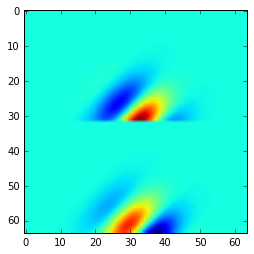

In [10]:
plt.imshow( 
f_gpu.get()
)

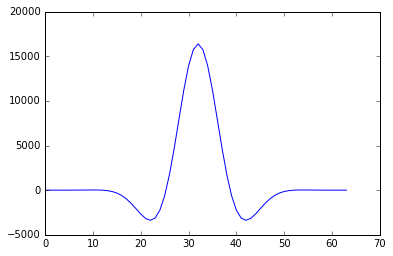

In [11]:
plt.plot( f33_gpu.get().real.reshape(64)  )

In [12]:
def ReconstructFFT2D_axesSplit_0(f,f65):
    n = f.shape[0]
    
    freal_half = f_gpu.get()[:n/2,:]
    freal      = np.append( freal_half ,  f65.real.reshape(1,f65.size) , axis=0)
    freal      = np.append( freal      ,  freal_half[:0:-1,:]          ,axis=0)
    
    fimag_half = f_gpu.get()[n/2:,:]
    fimag      = np.append( fimag_half ,   f65.imag.reshape(1,f65.size)  ,axis=0)
    fimag      = np.append( fimag      ,   -fimag_half[:0:-1,:]           ,axis=0)
        
    return freal + 1j*fimag 

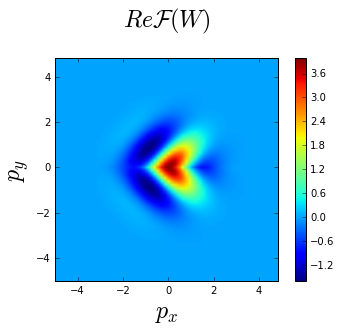

In [13]:
plt.imshow( 
        ReconstructFFT2D_axesSplit_0( f_gpu.get() , f33_gpu.get()   ).real/float(size), 
        extent=[-p_amplitude , p_amplitude-dp, -p_amplitude , p_amplitude-dp] , origin='lower')

plt.colorbar()

axis_font = {'size':'24'}
plt.text( -2, 6.2, '$Re \\mathcal{F}(W)$',  **axis_font )

plt.xlim(-p_amplitude , p_amplitude-dp)
plt.ylim(-p_amplitude , p_amplitude-dp)

plt.xlabel('$p_x$',**axis_font)
plt.ylabel('$p_y$',**axis_font)

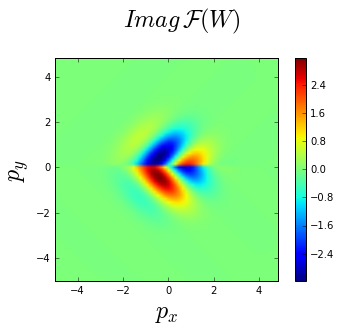

In [14]:

plt.imshow( 
        ReconstructFFT2D_axesSplit_0( f_gpu.get() , f33_gpu.get()   ).imag/float(size), 
        extent=[-p_amplitude , p_amplitude-dp, -p_amplitude , p_amplitude-dp] , origin='lower')

plt.colorbar()

axis_font = {'size':'24'}
plt.text( -2, 6.2, '$Imag\, \\mathcal{F}(W)$',  **axis_font )

plt.xlim(-p_amplitude , p_amplitude-dp)
plt.ylim(-p_amplitude , p_amplitude-dp)

plt.xlabel('$p_x$',**axis_font)
plt.ylabel('$p_y$',**axis_font)

#### Central Section: $p_y =0$

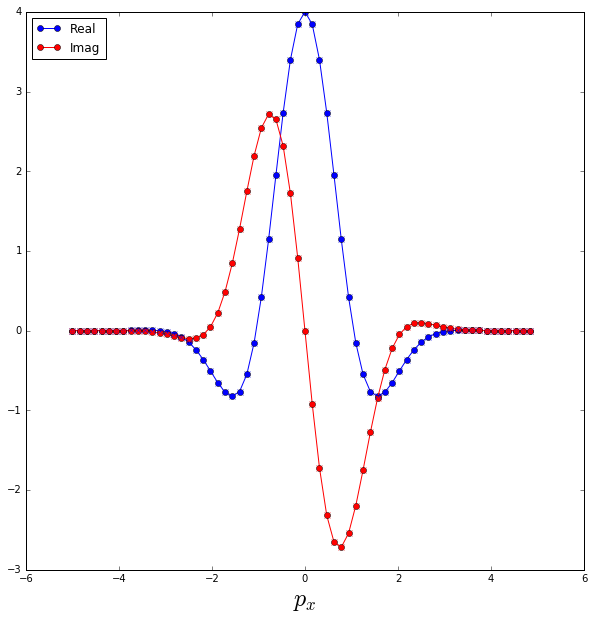

In [15]:
plt.figure(figsize=(10,10))

plt.plot( p_range, 
    ReconstructFFT2D_axesSplit_0( f_gpu.get() , f33_gpu.get()   )[32,:].real/float(size),
'o-' , label='Real')

plt.plot( p_range,
    ReconstructFFT2D_axesSplit_0( f_gpu.get() , f33_gpu.get()   )[32,:].imag/float(size),
'ro-' , label='Imag')

plt.xlabel('$p_x$',**axis_font)

plt.plot( p_range  ,  4*fftGaussian(p_range,mu_x,sigma_x).real ,'bx');
plt.plot( p_range  ,  4*fftGaussian(p_range,mu_x,sigma_x).imag ,'rx');

plt.legend(loc='upper left')

### Inverse Transform

In [16]:
# Executing iFFT

cuda_ifaft( int(f_gpu.gpudata), int(f33_gpu.gpudata), dx, -delta, segment_axes1, axes1, makeC2C, axesSplit_0 )
cuda_ifaft( int(f_gpu.gpudata), int(f33_gpu.gpudata), dx, -delta, segment_axes0, axes0, makeC2R, axesSplit_0 )

1

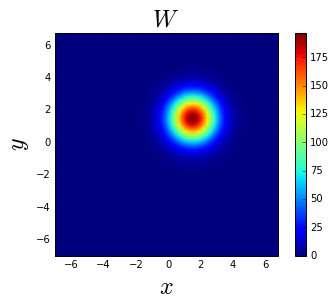

In [17]:
plt.imshow( f_gpu.get()/(float(size*size))  ,
           extent=[-x_amplitude , x_amplitude-dx, -x_amplitude, x_amplitude-dx], origin='lower' )

plt.colorbar()

axis_font = {'size':'24'}
plt.text( -1, 7.2, '$W$',  **axis_font )

plt.xlim(-x_amplitude , x_amplitude-dx)
plt.ylim(-x_amplitude , x_amplitude-dx)

plt.xlabel('$x$',**axis_font)
plt.ylabel('$y$',**axis_font)

## $W$ TRANSFORM FROM AXES-1

### After the transfom, f_gpu[:, :32] contains real values and f_gpu[:, 32:] contains imaginary values. f33_gpu contains the 33th. complex values  

In [18]:
f =  Gaussian(x,mu_x,sigma_x)*Gaussian(y,mu_y,sigma_y)

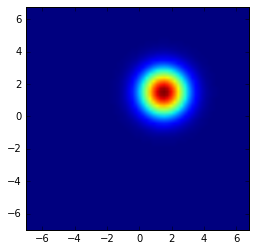

In [19]:
plt.imshow( f, extent=[-x_amplitude , x_amplitude-dx, -x_amplitude , x_amplitude-dx] , origin='lower')


In [20]:

f33 = np.zeros( [64, 1], dtype = np.complex64 )


In [21]:
# One gpu array.

f_gpu = gpuarray.to_gpu( np.ascontiguousarray( f , dtype = np.float32 ) )
f33_gpu = gpuarray.to_gpu( np.ascontiguousarray( f33 , dtype = np.complex64 ) )

### Forward Transform

In [22]:
# Executing FFT

cuda_faft( int(f_gpu.gpudata), int(f33_gpu.gpudata), dx, delta, segment_axes1, axes1, makeR2C, axesSplit_1 )
cuda_faft( int(f_gpu.gpudata), int(f33_gpu.gpudata), dx, delta, segment_axes0, axes0, makeC2C, axesSplit_1 )

1

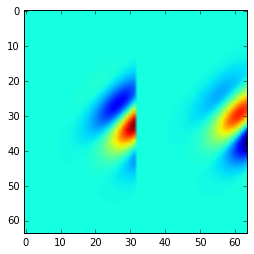

In [23]:
plt.imshow( 
f_gpu.get()
)

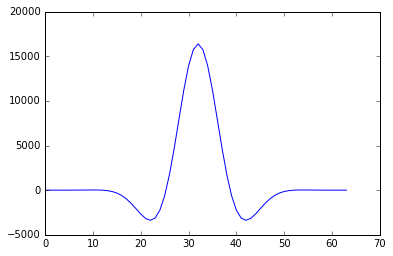

In [24]:
plt.plot( f33_gpu.get().real.reshape(64)  )

In [25]:
def ReconstructFFT2D_axesSplit_1(f,f65):
    n = f.shape[0]
    
    freal_half = f_gpu.get()[:,:n/2]
    
    freal      = np.append( freal_half ,  f65.real.reshape(f65.size,1) , axis=1)
    freal      = np.append( freal      ,  freal_half[:,:0:-1]          , axis=1)
    
    fimag_half = f_gpu.get()[:,n/2:]
    fimag      = np.append( fimag_half ,  f65.imag.reshape(f65.size,1)  ,axis=1)
    fimag      = np.append( fimag      ,   -fimag_half[:,:0:-1]          ,axis=1)
        
    return  freal + 1j*fimag

In [26]:
ReconstructFFT2D_axesSplit_1( f_gpu.get() , f33_gpu.get()   ).shape

(64, 64)

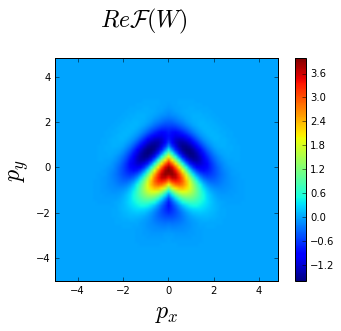

In [27]:
plt.imshow( ReconstructFFT2D_axesSplit_1( f_gpu.get() , f33_gpu.get()   ).real/float(size), 
           extent=[-p_amplitude , p_amplitude-dp, -p_amplitude, p_amplitude-dp] )

plt.colorbar()

axis_font = {'size':'24'}
plt.text( -3.0, 6.2, '$Re \\mathcal{F}(W)$',  **axis_font )

plt.xlim(-p_amplitude , p_amplitude-dp)
plt.ylim(-p_amplitude , p_amplitude-dp)

plt.xlabel('$p_x$',**axis_font)
plt.ylabel('$p_y$',**axis_font)

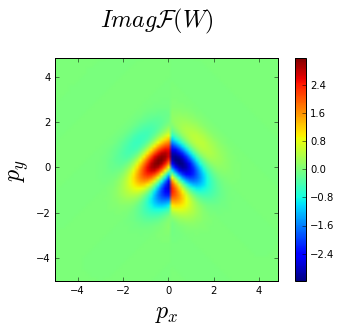

In [28]:
plt.imshow( ReconstructFFT2D_axesSplit_1( f_gpu.get() , f33_gpu.get()   ).imag/float(size), 
           extent=[-p_amplitude , p_amplitude-dp, -p_amplitude, p_amplitude-dp] )

plt.colorbar()

axis_font = {'size':'24'}
plt.text( -3.0, 6.2, '$Imag \\mathcal{F}(W)$',  **axis_font )

plt.xlim(-p_amplitude , p_amplitude-dp)
plt.ylim(-p_amplitude , p_amplitude-dp)

plt.xlabel('$p_x$',**axis_font)
plt.ylabel('$p_y$',**axis_font)

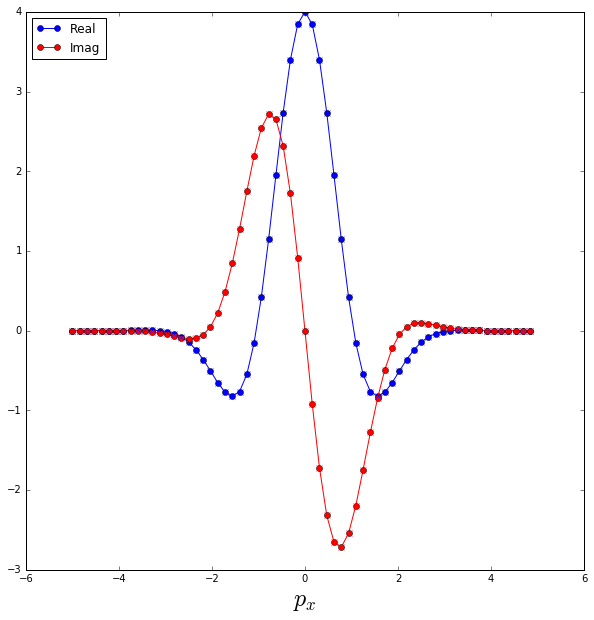

In [29]:
plt.figure(figsize=(10,10))

plt.plot( p_range, 
    ReconstructFFT2D_axesSplit_1( f_gpu.get() , f33_gpu.get()   )[32,:].real/float(size),
'o-' , label='Real')

plt.plot( p_range,
    ReconstructFFT2D_axesSplit_1( f_gpu.get() , f33_gpu.get()   )[32,:].imag/float(size),
'ro-' , label='Imag')

plt.xlabel('$p_x$',**axis_font)

plt.plot( p_range  ,  4*fftGaussian(p_range,mu_x,sigma_x).real ,'bx');
plt.plot( p_range  ,  4*fftGaussian(p_range,mu_x,sigma_x).imag ,'rx');

plt.legend(loc='upper left')

### Inverse Transform

In [30]:
# Executing iFFT


cuda_ifaft( int(f_gpu.gpudata), int(f33_gpu.gpudata), dx, -delta, segment_axes0, axes0, makeC2C, axesSplit_1 )
cuda_ifaft( int(f_gpu.gpudata), int(f33_gpu.gpudata), dx, -delta, segment_axes1, axes1, makeC2R, axesSplit_1 )

1

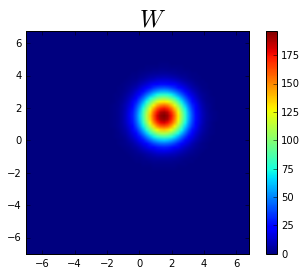

In [31]:
plt.imshow( f_gpu.get()/float(size)**2 ,
           extent=[-x_amplitude , x_amplitude-dx, -x_amplitude , x_amplitude-dx] , origin='lower')

axis_font = {'size':'24'}
plt.text( 0., 7.1, '$W$' , **axis_font)
plt.colorbar()